### Load libraries

In [1]:
import sys

import matplotlib.pyplot as plt
import torch
import wandb

In [2]:
sys.path.append("../..")
from src.ax.attack.FastPGD import FastPGD
from src.ax.attack.AllPairsPGD import AllPairsPGD
from src.ax.attack.teacher_loss import TeacherCrossEntropy
from src.ax.data import cifar
from src.ax.train import ExperimentConfig, evaluate

### Load models

In [3]:
cfg = ExperimentConfig(
    teacher_ckpt_path="/home/gridsan/groups/ccg/wandb/run-reconstructed-1s50k73h/files/model.ckpt",
)

In [4]:
# Teacher
net_teacher = cfg.get_net().cuda()
net_teacher = net_teacher.to(memory_format=torch.channels_last)  # type: ignore
net_teacher.load_state_dict(torch.load(cfg.teacher_ckpt_path))  # type: ignore
net_teacher.eval();  # type: ignore

In [5]:
# Trained student
# https://wandb.ai/data-frugal-learning/adv-train/runs/pwhuv8vd
STUDENT_CKPT_PATH = (
    "/home/gridsan/groups/ccg/wandb/run-20220823_151604-pwhuv8vd/files/model.ckpt"
)

net_student = cfg.get_net().cuda()
net_student = net_student.to(memory_format=torch.channels_last)  # type: ignore
net_student.load_state_dict(torch.load(STUDENT_CKPT_PATH))  # type: ignore
net_student.eval(); # type: ignore

### Natural accuracy

In [6]:
loader_test = cifar.get_loader(
    split="test",
    batch_size=512,
    indices=range(512),
)


class NoOpAttack:
    def __init__(self, cfg: ExperimentConfig):
        self.eps = cfg.adv_eps_eval

    def __call__(self, x, _):
        return x


def show_imgs_8(images: list[wandb.Image]):
    plt.figure(figsize=(8, 1.5))
    for idx, img in enumerate(images[:8]):
        plt.subplot(2, 4, idx + 1)
        plt.imshow(img.image)  # type: ignore
        plt.axis("off")


  0%|          | 0/1 [00:00<?, ?it/s]

{'acc_nat': Metric(data=1.0, summary='max'), 'acc_adv': Metric(data=1.0, summary='max'), 'loss_nat': Metric(data=0.32593265175819397, summary='min'), 'loss_adv': Metric(data=0.32593265175819397, summary='min'), 'acc': Metric(data=1.0, summary='max'), 'loss': Metric(data=0.32593265175819397, summary='min')}


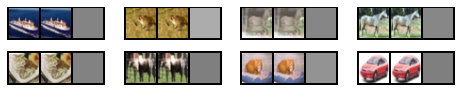

In [7]:
metrics, imgs = evaluate(
    net=net_teacher,
    loader=loader_test,
    attack=NoOpAttack(cfg), # type: ignore
    cfg=cfg,
    teacher_net=net_teacher,
)
print(metrics)
show_imgs_8(imgs)


  0%|          | 0/1 [00:00<?, ?it/s]

{'acc_nat': Metric(data=0.966796875, summary='max'), 'acc_adv': Metric(data=0.966796875, summary='max'), 'loss_nat': Metric(data=0.07325710356235504, summary='min'), 'loss_adv': Metric(data=0.07325710356235504, summary='min'), 'acc': Metric(data=0.966796875, summary='max'), 'loss': Metric(data=0.07325710356235504, summary='min')}


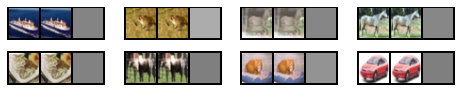

In [8]:
metrics, imgs = evaluate(
    net=net_student,
    loader=loader_test,
    attack=NoOpAttack(cfg), # type: ignore
    cfg=cfg,
    teacher_net=net_teacher,
)
print(metrics)
show_imgs_8(imgs)

### Run attack

In [9]:
cfg.pgd_steps = 10
cfg.adv_eps_eval = 8 / 255

attack_ap = AllPairsPGD(
    net1=net_student,
    net2=net_teacher,
    eps=cfg.adv_eps_eval,
    alpha=cfg.adv_eps_eval / cfg.pgd_steps * 2.3 if cfg.pgd_steps > 0 else 0,
    steps=cfg.pgd_steps,
    random_start=True,
    verbose=True,
)

attack_orig = FastPGD(
    model=net_student,
    eps=cfg.adv_eps_eval,
    alpha=cfg.adv_eps_eval / cfg.pgd_steps * 2.3 if cfg.pgd_steps > 0 else 0,
    steps=cfg.pgd_steps,
    random_start=True,
    loss=TeacherCrossEntropy(net_teacher, use_softmax=False, symmetrize=False),
)

attack_sym = FastPGD(
    model=net_student,
    eps=cfg.adv_eps_eval,
    alpha=cfg.adv_eps_eval / cfg.pgd_steps * 2.3 if cfg.pgd_steps > 0 else 0,
    steps=cfg.pgd_steps,
    random_start=True,
    loss=TeacherCrossEntropy(net_teacher, use_softmax=False, symmetrize=True),
)

Using all pairs loss


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

Attack results: {'acc_nat': Metric(data=0.966796875, summary='max'), 'acc_adv': Metric(data=0.640625, summary='max'), 'loss_nat': Metric(data=1.9128544330596924, summary='min'), 'loss_adv': Metric(data=1.7254050970077515, summary='min'), 'acc': Metric(data=0.640625, summary='max'), 'loss': Metric(data=1.7254050970077515, summary='min')}


  0%|          | 0/1 [00:00<?, ?it/s]

Natural results: {'acc_nat': Metric(data=0.966796875, summary='max'), 'acc_adv': Metric(data=0.966796875, summary='max'), 'loss_nat': Metric(data=1.9128544330596924, summary='min'), 'loss_adv': Metric(data=1.9128544330596924, summary='min'), 'acc': Metric(data=0.966796875, summary='max'), 'loss': Metric(data=1.9128544330596924, summary='min')}


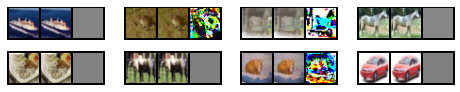

In [10]:
cfg.teacher_use_softmax = True
print("Using all pairs loss")

metrics, imgs = evaluate(
    net=net_student,
    loader=loader_test,
    attack=attack_ap,
    cfg=cfg,
    teacher_net=net_teacher,
)
show_imgs_8(imgs)
print("Attack results:", metrics)

metrics, _ = evaluate(
    net=net_student,
    loader=loader_test,
    attack=NoOpAttack(cfg), # type: ignore
    cfg=cfg,
    teacher_net=net_teacher,
)
print("Natural results:", metrics)

Using original loss


  0%|          | 0/1 [00:00<?, ?it/s]

Attack results: {'acc_nat': Metric(data=0.966796875, summary='max'), 'acc_adv': Metric(data=0.896484375, summary='max'), 'loss_nat': Metric(data=1.9128544330596924, summary='min'), 'loss_adv': Metric(data=1.78434419631958, summary='min'), 'acc': Metric(data=0.896484375, summary='max'), 'loss': Metric(data=1.78434419631958, summary='min')}


  0%|          | 0/1 [00:00<?, ?it/s]

Natural results: {'acc_nat': Metric(data=0.966796875, summary='max'), 'acc_adv': Metric(data=0.966796875, summary='max'), 'loss_nat': Metric(data=1.9128544330596924, summary='min'), 'loss_adv': Metric(data=1.9128544330596924, summary='min'), 'acc': Metric(data=0.966796875, summary='max'), 'loss': Metric(data=1.9128544330596924, summary='min')}


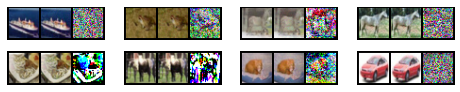

In [11]:
cfg.teacher_use_softmax = True
print("Using original loss")

metrics, imgs = evaluate(
    net=net_student,
    loader=loader_test,
    attack=attack_orig,
    cfg=cfg,
    teacher_net=net_teacher,
)
show_imgs_8(imgs)
print("Attack results:", metrics)

metrics, _ = evaluate(
    net=net_student,
    loader=loader_test,
    attack=NoOpAttack(cfg), # type: ignore
    cfg=cfg,
    teacher_net=net_teacher,
)
print("Natural results:", metrics)

Using symmetric loss


  0%|          | 0/1 [00:00<?, ?it/s]

Attack results: {'acc_nat': Metric(data=0.966796875, summary='max'), 'acc_adv': Metric(data=0.884765625, summary='max'), 'loss_nat': Metric(data=0.07325710356235504, summary='min'), 'loss_adv': Metric(data=0.2840220630168915, summary='min'), 'acc': Metric(data=0.884765625, summary='max'), 'loss': Metric(data=0.2840220630168915, summary='min')}


  0%|          | 0/1 [00:00<?, ?it/s]

Natural results: {'acc_nat': Metric(data=0.966796875, summary='max'), 'acc_adv': Metric(data=0.966796875, summary='max'), 'loss_nat': Metric(data=0.07325710356235504, summary='min'), 'loss_adv': Metric(data=0.07325710356235504, summary='min'), 'acc': Metric(data=0.966796875, summary='max'), 'loss': Metric(data=0.07325710356235504, summary='min')}


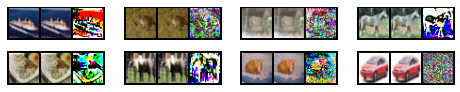

In [12]:
cfg.teacher_use_softmax = False
print("Using symmetric loss")

metrics, imgs = evaluate(
    net=net_student,
    loader=loader_test,
    attack=attack_sym,
    cfg=cfg,
    teacher_net=net_teacher,
)
show_imgs_8(imgs)
print("Attack results:", metrics)

metrics, _ = evaluate(
    net=net_student,
    loader=loader_test,
    attack=NoOpAttack(cfg), # type: ignore
    cfg=cfg,
    teacher_net=net_teacher,
)
print("Natural results:", metrics)

### Conclusions
We want to attack with the same loss we evaluate with!

Note: Attacking soft loss doesn't necessarily make accuracy go down.